# Automatic Device Selection with OpenVINO™

The [Auto device](https://docs.openvino.ai/2024/openvino-workflow/running-inference/inference-devices-and-modes/auto-device-selection.html) (or AUTO in short) selects the most suitable device for inference by considering the model precision, power efficiency and processing capability of the available [compute devices](https://docs.openvino.ai/2024/about-openvino/compatibility-and-support/supported-devices.html). The model precision (such as `FP32`, `FP16`, `INT8`, etc.) is the first consideration to filter out the devices that cannot run the network efficiently.

Next, if dedicated accelerators are available, these devices are preferred (for example, integrated and discrete [GPU](https://docs.openvino.ai/2024/openvino-workflow/running-inference/inference-devices-and-modes/gpu-device.html)). [CPU](https://docs.openvino.ai/2024/openvino-workflow/running-inference/inference-devices-and-modes/cpu-device.html) is used as the default "fallback device". Keep in mind that AUTO makes this selection only once, during the loading of a model. 

When using accelerator devices such as GPUs, loading models to these devices may take a long time. To address this challenge for applications that require fast first inference response, AUTO starts inference immediately on the CPU and then transparently shifts inference to the GPU, once it is ready. This dramatically reduces the time to execute first inference.


![auto](https://user-images.githubusercontent.com/15709723/161451847-759e2bdb-70bc-463d-9818-400c0ccf3c16.png)


#### Table of contents:

- [Import modules and create Core](#Import-modules-and-create-Core)
- [Convert the model to OpenVINO IR format](#Convert-the-model-to-OpenVINO-IR-format)
- [(1) Simplify selection logic](#(1)-Simplify-selection-logic)
    - [Default behavior of Core::compile_model API without device_name](#Default-behavior-of-Core::compile_model-API-without-device_name)
    - [Explicitly pass AUTO as device_name to Core::compile_model API](#Explicitly-pass-AUTO-as-device_name-to-Core::compile_model-API)
- [(2) Improve the first inference latency](#(2)-Improve-the-first-inference-latency)
    - [Load an Image](#Load-an-Image)
    - [Load the model to GPU device and perform inference](#Load-the-model-to-GPU-device-and-perform-inference)
    - [Load the model using AUTO device and do inference](#Load-the-model-using-AUTO-device-and-do-inference)
- [(3) Achieve different performance for different targets](#(3)-Achieve-different-performance-for-different-targets)
    - [Class and callback definition](#Class-and-callback-definition)
    - [Inference with THROUGHPUT hint](#Inference-with-THROUGHPUT-hint)
    - [Inference with LATENCY hint](#Inference-with-LATENCY-hint)
    - [Difference in FPS and latency](#Difference-in-FPS-and-latency)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/auto-device/auto-device.ipynb" />


## Import modules and create Core
[back to top ⬆️](#Table-of-contents:)


In [1]:
import platform

# Install required packages
%pip install -q "openvino>=2023.1.0" "matplotlib>=3.4" Pillow torch torchvision tqdm --extra-index-url https://download.pytorch.org/whl/cpu

if platform.system() == "Darwin":
    %pip install -q "numpy<2.0.0"

In [2]:
import time
import sys

import openvino as ov

from IPython.display import Markdown, display

core = ov.Core()

if not any("GPU" in device for device in core.available_devices):
    display(
        Markdown(
            '<div class="alert alert-block alert-danger"><b>Warning: </b> A GPU device is not available. This notebook requires GPU device to have meaningful results. </div>'
        )
    )

## Convert the model to OpenVINO IR format
[back to top ⬆️](#Table-of-contents:)

This tutorial uses [resnet50](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html#resnet50) model from [torchvision](https://pytorch.org/vision/main/index.html?highlight=torchvision#module-torchvision) library.
ResNet 50 is image classification model pre-trained on ImageNet dataset described in paper ["Deep Residual Learning for Image Recognition"](https://arxiv.org/abs/1512.03385).
From OpenVINO 2023.0, we can directly convert a model from the PyTorch format to the OpenVINO IR format using model conversion API. To convert model, we should provide model object instance into `ov.convert_model` function, optionally, we can specify input shape for conversion (by default models from PyTorch converted with dynamic input shapes). `ov.convert_model` returns openvino.runtime.Model object ready to be loaded on a device with `ov.compile_model` or serialized for next usage with `ov.save_model`. 

For more information about model conversion API, see this [page](https://docs.openvino.ai/2024/openvino-workflow/model-preparation.html).

In [3]:
import torchvision
from pathlib import Path

base_model_dir = Path("./model")
base_model_dir.mkdir(exist_ok=True)
model_path = base_model_dir / "resnet50.xml"

if not model_path.exists():
    pt_model = torchvision.models.resnet50(weights="DEFAULT")
    ov_model = ov.convert_model(pt_model, input=[[1, 3, 224, 224]])
    ov.save_model(ov_model, str(model_path))
    print("IR model saved to {}".format(model_path))
else:
    print("Read IR model from {}".format(model_path))
    ov_model = core.read_model(model_path)

Read IR model from model/resnet50.xml


## (1) Simplify selection logic
[back to top ⬆️](#Table-of-contents:)

### Default behavior of Core::compile_model API without device_name
[back to top ⬆️](#Table-of-contents:)


By default, `compile_model` API will select **AUTO** as `device_name` if no device is specified.

In [4]:
import openvino.properties.log as log


# Set LOG_LEVEL to LOG_INFO.
core.set_property("AUTO", {log.level(): log.Level.INFO})

# Load the model onto the target device.
compiled_model = core.compile_model(ov_model)

if isinstance(compiled_model, ov.CompiledModel):
    print("Successfully compiled model without a device_name.")

Successfully compiled model without a device_name.


In [5]:
# Deleted model will wait until compiling on the selected device is complete.
del compiled_model
print("Deleted compiled_model")

Deleted compiled_model


### Explicitly pass AUTO as device_name to Core::compile_model API
[back to top ⬆️](#Table-of-contents:)

It is optional, but passing AUTO explicitly as `device_name` may improve readability of your code.

In [6]:
# Set LOG_LEVEL to LOG_NONE.
core.set_property("AUTO", {log.level(): log.Level.NO})

compiled_model = core.compile_model(model=ov_model, device_name="AUTO")

if isinstance(compiled_model, ov.CompiledModel):
    print("Successfully compiled model using AUTO.")

Successfully compiled model using AUTO.


In [7]:
# Deleted model will wait until compiling on the selected device is complete.
del compiled_model
print("Deleted compiled_model")

Deleted compiled_model


## (2) Improve the first inference latency
[back to top ⬆️](#Table-of-contents:)

One of the benefits of using AUTO device selection is reducing FIL (first inference latency). FIL is the model compilation time combined with the first inference execution time. Using the CPU device explicitly will produce the shortest first inference latency, as the OpenVINO graph representation loads quickly on CPU, using just-in-time (JIT) compilation. The challenge is with GPU devices since OpenCL graph complication to GPU-optimized kernels takes a few seconds to complete. This initialization time may be intolerable for some applications. To avoid this delay, the AUTO uses CPU transparently as the first inference device until GPU is ready.

### Load an Image
[back to top ⬆️](#Table-of-contents:)

torchvision library provides model specific input transformation function, we will reuse it for preparing input data.

In [ ]:
# Fetch `notebook_utils` module
import requests

r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py")
open("notebook_utils.py", "w").write(r.text)

from notebook_utils import download_file

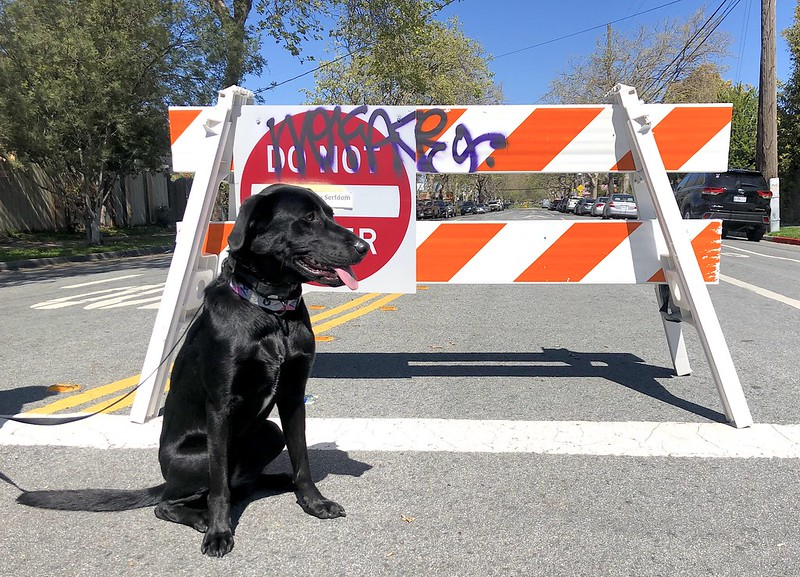

In [8]:
from PIL import Image

# Download the image from the openvino_notebooks storage
image_filename = download_file(
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco.jpg",
    directory="data",
)

image = Image.open(str(image_filename))
input_transform = torchvision.models.ResNet50_Weights.DEFAULT.transforms()

input_tensor = input_transform(image)
input_tensor = input_tensor.unsqueeze(0).numpy()
image

### Load the model to GPU device and perform inference
[back to top ⬆️](#Table-of-contents:)


In [9]:
if not any("GPU" in device for device in core.available_devices):
    print(f"A GPU device is not available. Available devices are: {core.available_devices}")
else:
    # Start time.
    gpu_load_start_time = time.perf_counter()
    compiled_model = core.compile_model(model=ov_model, device_name="GPU")  # load to GPU

    # Execute the first inference.
    results = compiled_model(input_tensor)[0]

    # Measure time to the first inference.
    gpu_fil_end_time = time.perf_counter()
    gpu_fil_span = gpu_fil_end_time - gpu_load_start_time
    print(f"Time to load model on GPU device and get first inference: {gpu_fil_end_time-gpu_load_start_time:.2f} seconds.")
    del compiled_model

Time to load model on GPU device and get first inference: 0.54 seconds.


### Load the model using AUTO device and do inference
[back to top ⬆️](#Table-of-contents:)

When GPU is the best available device, the first few inferences will be executed on CPU until GPU is ready.

In [10]:
# Start time.
auto_load_start_time = time.perf_counter()
compiled_model = core.compile_model(model=ov_model)  # The device_name is AUTO by default.

# Execute the first inference.
results = compiled_model(input_tensor)[0]


# Measure time to the first inference.
auto_fil_end_time = time.perf_counter()
auto_fil_span = auto_fil_end_time - auto_load_start_time
print(f"Time to load model using AUTO device and get first inference: {auto_fil_end_time-auto_load_start_time:.2f} seconds.")

Time to load model using AUTO device and get first inference: 0.16 seconds.


In [11]:
# Deleted model will wait for compiling on the selected device to complete.
del compiled_model

## (3) Achieve different performance for different targets
[back to top ⬆️](#Table-of-contents:)

It is an advantage to define **performance hints** when using Automatic Device Selection. By specifying a **THROUGHPUT** or **LATENCY** hint, AUTO optimizes the performance based on the desired metric. The **THROUGHPUT** hint delivers higher frame per second (FPS) performance than the **LATENCY** hint, which delivers lower latency. The performance hints do not require any device-specific settings and they are completely portable between devices – meaning AUTO can configure the performance hint on whichever device is being used.

For more information, refer to the [Performance Hints](https://docs.openvino.ai/2024/openvino-workflow/running-inference/inference-devices-and-modes/auto-device-selection.html#performance-hints-for-auto) section of [Automatic Device Selection](https://docs.openvino.ai/2024/openvino-workflow/running-inference/inference-devices-and-modes/auto-device-selection.html) article.

### Class and callback definition
[back to top ⬆️](#Table-of-contents:)


In [12]:
class PerformanceMetrics:
    """
    Record the latest performance metrics (fps and latency), update the metrics in each @interval seconds
    :member: fps: Frames per second, indicates the average number of inferences executed each second during the last @interval seconds.
    :member: latency: Average latency of inferences executed in the last @interval seconds.
    :member: start_time: Record the start timestamp of onging @interval seconds duration.
    :member: latency_list: Record the latency of each inference execution over @interval seconds duration.
    :member: interval: The metrics will be updated every @interval seconds
    """

    def __init__(self, interval):
        """
        Create and initilize one instance of class PerformanceMetrics.
        :param: interval: The metrics will be updated every @interval seconds
        :returns:
            Instance of PerformanceMetrics
        """
        self.fps = 0
        self.latency = 0

        self.start_time = time.perf_counter()
        self.latency_list = []
        self.interval = interval

    def update(self, infer_request: ov.InferRequest) -> bool:
        """
        Update the metrics if current ongoing @interval seconds duration is expired. Record the latency only if it is not expired.
        :param: infer_request: InferRequest returned from inference callback, which includes the result of inference request.
        :returns:
            True, if metrics are updated.
            False, if @interval seconds duration is not expired and metrics are not updated.
        """
        self.latency_list.append(infer_request.latency)
        exec_time = time.perf_counter() - self.start_time
        if exec_time >= self.interval:
            # Update the performance metrics.
            self.start_time = time.perf_counter()
            self.fps = len(self.latency_list) / exec_time
            self.latency = sum(self.latency_list) / len(self.latency_list)
            print(f"throughput: {self.fps: .2f}fps, latency: {self.latency: .2f}ms, time interval:{exec_time: .2f}s")
            sys.stdout.flush()
            self.latency_list = []
            return True
        else:
            return False


class InferContext:
    """
    Inference context. Record and update peforamnce metrics via @metrics, set @feed_inference to False once @remaining_update_num <=0
    :member: metrics: instance of class PerformanceMetrics
    :member: remaining_update_num: the remaining times for peforamnce metrics updating.
    :member: feed_inference: if feed inference request is required or not.
    """

    def __init__(self, update_interval, num):
        """
        Create and initilize one instance of class InferContext.
        :param: update_interval: The performance metrics will be updated every @update_interval seconds. This parameter will be passed to class PerformanceMetrics directly.
        :param: num: The number of times performance metrics are updated.
        :returns:
            Instance of InferContext.
        """
        self.metrics = PerformanceMetrics(update_interval)
        self.remaining_update_num = num
        self.feed_inference = True

    def update(self, infer_request: ov.InferRequest):
        """
        Update the context. Set @feed_inference to False if the number of remaining performance metric updates (@remaining_update_num) reaches 0
        :param: infer_request: InferRequest returned from inference callback, which includes the result of inference request.
        :returns: None
        """
        if self.remaining_update_num <= 0:
            self.feed_inference = False

        if self.metrics.update(infer_request):
            self.remaining_update_num = self.remaining_update_num - 1
            if self.remaining_update_num <= 0:
                self.feed_inference = False


def completion_callback(infer_request: ov.InferRequest, context) -> None:
    """
    callback for the inference request, pass the @infer_request to @context for updating
    :param: infer_request: InferRequest returned for the callback, which includes the result of inference request.
    :param: context: user data which is passed as the second parameter to AsyncInferQueue:start_async()
    :returns: None
    """
    context.update(infer_request)


# Performance metrics update interval (seconds) and number of times.
metrics_update_interval = 10
metrics_update_num = 6

### Inference with THROUGHPUT hint
[back to top ⬆️](#Table-of-contents:)

Loop for inference and update the FPS/Latency every @metrics_update_interval seconds.

In [13]:
import openvino.properties.hint as hints


THROUGHPUT_hint_context = InferContext(metrics_update_interval, metrics_update_num)

print("Compiling Model for AUTO device with THROUGHPUT hint")
sys.stdout.flush()

compiled_model = core.compile_model(model=ov_model, config={hints.performance_mode(): hints.PerformanceMode.THROUGHPUT})

infer_queue = ov.AsyncInferQueue(compiled_model, 0)  # Setting to 0 will query optimal number by default.
infer_queue.set_callback(completion_callback)

print(f"Start inference, {metrics_update_num: .0f} groups of FPS/latency will be measured over {metrics_update_interval: .0f}s intervals")
sys.stdout.flush()

while THROUGHPUT_hint_context.feed_inference:
    infer_queue.start_async(input_tensor, THROUGHPUT_hint_context)

infer_queue.wait_all()

# Take the FPS and latency of the latest period.
THROUGHPUT_hint_fps = THROUGHPUT_hint_context.metrics.fps
THROUGHPUT_hint_latency = THROUGHPUT_hint_context.metrics.latency

print("Done")

del compiled_model

Compiling Model for AUTO device with THROUGHPUT hint
Start inference,  6 groups of FPS/latency will be measured over  10s intervals
throughput:  215.00fps, latency:  53.28ms, time interval: 10.00s
throughput:  227.40fps, latency:  52.03ms, time interval: 10.00s
throughput:  234.33fps, latency:  50.43ms, time interval: 10.00s
throughput:  231.23fps, latency:  51.10ms, time interval: 10.02s
throughput:  225.68fps, latency:  52.40ms, time interval: 10.00s
throughput:  221.66fps, latency:  53.41ms, time interval: 10.01s
Done


### Inference with LATENCY hint
[back to top ⬆️](#Table-of-contents:)

Loop for inference and update the FPS/Latency for each @metrics_update_interval seconds

In [14]:
LATENCY_hint_context = InferContext(metrics_update_interval, metrics_update_num)

print("Compiling Model for AUTO Device with LATENCY hint")
sys.stdout.flush()

compiled_model = core.compile_model(model=ov_model, config={hints.performance_mode(): hints.PerformanceMode.LATENCY})

# Setting to 0 will query optimal number by default.
infer_queue = ov.AsyncInferQueue(compiled_model, 0)
infer_queue.set_callback(completion_callback)

print(f"Start inference, {metrics_update_num: .0f} groups fps/latency will be out with {metrics_update_interval: .0f}s interval")
sys.stdout.flush()

while LATENCY_hint_context.feed_inference:
    infer_queue.start_async(input_tensor, LATENCY_hint_context)

infer_queue.wait_all()

# Take the FPS and latency of the latest period.
LATENCY_hint_fps = LATENCY_hint_context.metrics.fps
LATENCY_hint_latency = LATENCY_hint_context.metrics.latency

print("Done")

del compiled_model

Compiling Model for AUTO Device with LATENCY hint
Start inference,  6 groups fps/latency will be out with  10s interval
throughput:  130.40fps, latency:  7.03ms, time interval: 10.01s
throughput:  138.42fps, latency:  6.78ms, time interval: 10.01s
throughput:  136.80fps, latency:  6.86ms, time interval: 10.00s
throughput:  136.63fps, latency:  6.87ms, time interval: 10.01s
throughput:  138.39fps, latency:  6.78ms, time interval: 10.00s
throughput:  134.95fps, latency:  6.96ms, time interval: 10.00s
Done


### Difference in FPS and latency
[back to top ⬆️](#Table-of-contents:)


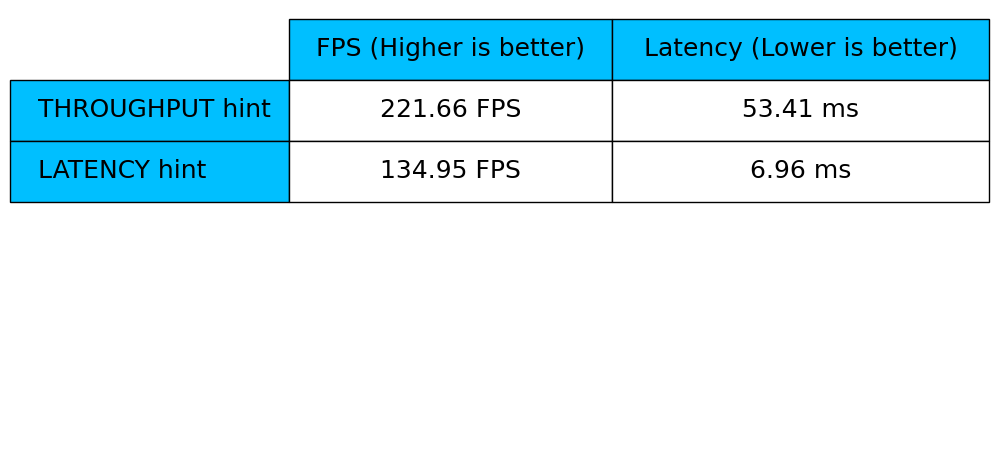

In [15]:
import matplotlib.pyplot as plt

TPUT = 0
LAT = 1
labels = ["THROUGHPUT hint", "LATENCY hint"]

fig1, ax1 = plt.subplots(1, 1)
fig1.patch.set_visible(False)
ax1.axis("tight")
ax1.axis("off")

cell_text = []
cell_text.append(
    [
        "%.2f%s" % (THROUGHPUT_hint_fps, " FPS"),
        "%.2f%s" % (THROUGHPUT_hint_latency, " ms"),
    ]
)
cell_text.append(["%.2f%s" % (LATENCY_hint_fps, " FPS"), "%.2f%s" % (LATENCY_hint_latency, " ms")])

table = ax1.table(
    cellText=cell_text,
    colLabels=["FPS (Higher is better)", "Latency (Lower is better)"],
    rowLabels=labels,
    rowColours=["deepskyblue"] * 2,
    colColours=["deepskyblue"] * 2,
    cellLoc="center",
    loc="upper left",
)
table.auto_set_font_size(False)
table.set_fontsize(18)
table.auto_set_column_width(0)
table.auto_set_column_width(1)
table.scale(1, 3)

fig1.tight_layout()
plt.show()

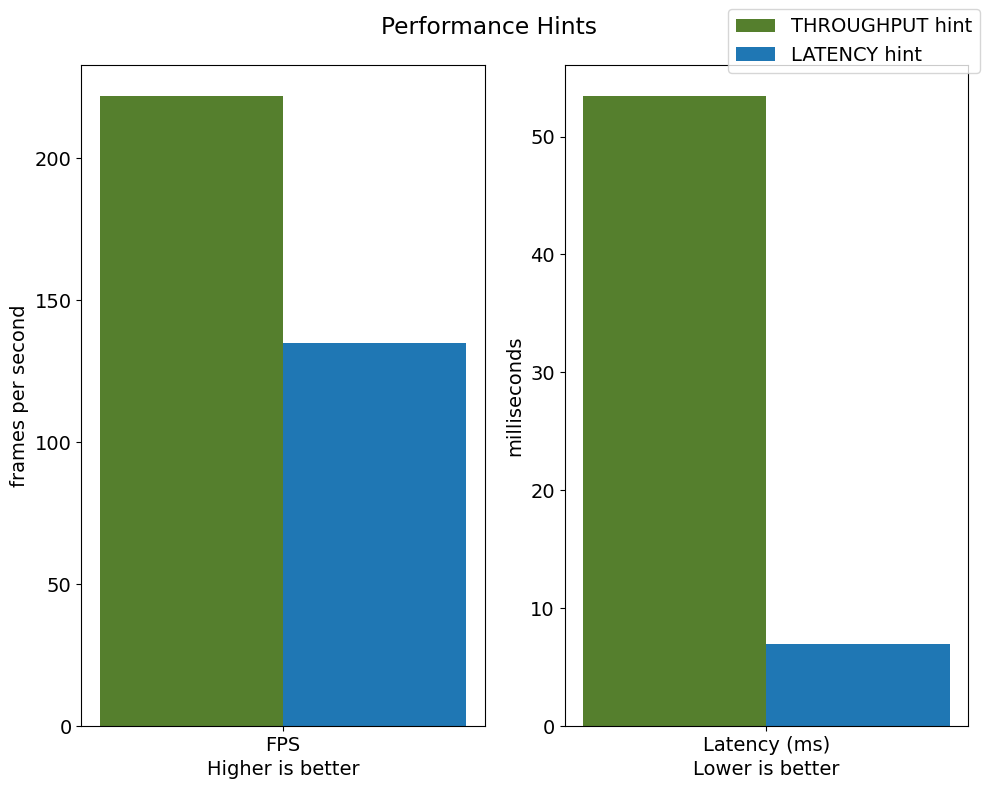

In [16]:
# Output the difference.
width = 0.4
fontsize = 14

plt.rc("font", size=fontsize)
fig, ax = plt.subplots(1, 2, figsize=(10, 8))

rects1 = ax[0].bar([0], THROUGHPUT_hint_fps, width, label=labels[TPUT], color="#557f2d")
rects2 = ax[0].bar([width], LATENCY_hint_fps, width, label=labels[LAT])
ax[0].set_ylabel("frames per second")
ax[0].set_xticks([width / 2])
ax[0].set_xticklabels(["FPS"])
ax[0].set_xlabel("Higher is better")

rects1 = ax[1].bar([0], THROUGHPUT_hint_latency, width, label=labels[TPUT], color="#557f2d")
rects2 = ax[1].bar([width], LATENCY_hint_latency, width, label=labels[LAT])
ax[1].set_ylabel("milliseconds")
ax[1].set_xticks([width / 2])
ax[1].set_xticklabels(["Latency (ms)"])
ax[1].set_xlabel("Lower is better")

fig.suptitle("Performance Hints")
fig.legend(labels, fontsize=fontsize)
fig.tight_layout()

plt.show()